In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import *
from sklearn.metrics import *

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings("ignore")

In [4]:
name = "LUAD"
path_CPM = "~/isomirs/Bimodal_mir22/differ_expr_genes/"+name+"/"+name+"_isomiR_5prime_CPM.tsv"
path_phenotype = "TCGA-"+name+".GDC_phenotype.tsv"

In [5]:
df = pd.read_csv(path_CPM, sep = '\t')
cond_cancer = df.columns.str.contains('-0[1-9][A-Z]', regex = True)
df_cancer = df[df.columns[cond_cancer]]

mirna22 = df_cancer.loc["hsa-miR-22-3p|+1"] 
left, right = mirna22[mirna22 < 11].index, mirna22[mirna22 > 11].index

In [6]:
data = pd.read_csv(path_phenotype, sep = '\t', index_col = 0)
cond_cancer = data.index.str.contains('-0[1-9][A-Z]', regex = True)
# data = data[cond_cancer]
# data = data.replace(r'Not Reported|not reported', np.NaN, regex = True)
# mask = (data.isna().sum() > data.shape[0]/2) | data.columns.str.contains('id|code|file_name', regex = True)
# data = data[data.columns[~mask]]
# data = data.drop(['batch_number'], axis = 1)

y = np.array([1 if i in left else 0 for i in data.index])

In [7]:
data['batch_number'].unique()

array(['258.59.0', '196.64.0', '222.60.0', '84.73.0', '213.60.0',
       '160.69.0', '232.55.0', '204.62.0', '144.70.0', '58.77.0',
       '166.67.0', '278.56.0', '37.77.0', '238.60.0', '264.60.0',
       '52.74.0', '119.76.0', '183.66.0', '423.36.0', '406.37.0',
       '34.10.0'], dtype=object)

In [8]:
data

,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision_other,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
submitter_id.samples,,,,,,,,,,,,,,,,,,,,,
TCGA-62-A46Y-01A,NaN,NaN,NaN,NaN,70.0,NaN,258.59.0,Nationwide Children's Hospital,NaN,NaN,...,NaN,False,NaN,True,NaN,Primary Tumor,1,NaN,released,Not Reported
TCGA-55-7903-01A,NaN,NaN,NaN,NaN,64.0,NaN,196.64.0,Nationwide Children's Hospital,TCGA-55-7903-F47840,A3E1AF4A-8377-4442-A98B-0F3218B1E228,...,0.2,False,0.5,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
TCGA-55-7903-11A,NaN,NaN,NaN,NaN,64.0,NaN,196.64.0,Nationwide Children's Hospital,TCGA-55-7903-F47840,A3E1AF4A-8377-4442-A98B-0F3218B1E228,...,0.4,False,0.8,NaN,NaN,Solid Tissue Normal,11,0.3,released,Not Reported
TCGA-97-8179-01A,NaN,NaN,NaN,NaN,72.0,NaN,222.60.0,Nationwide Children's Hospital,TCGA-97-8179-F44247,0FB47890-87D5-4A74-80DE-3F0F16E906DB,...,0.6,False,0.8,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
TCGA-64-5774-01A,NO,YES,NaN,YES,60.0,NaN,84.73.0,Nationwide Children's Hospital,TCGA-64-5774-F11400,4fe330f5-c1e9-4079-93ae-28cc03a377c3,...,0.6,False,1.4,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-17-Z040-11A,NaN,NaN,NaN,NaN,NaN,NaN,34.10.0,Washington University,NaN,NaN,...,NaN,False,NaN,NaN,NaN,Solid Tissue Normal,11,NaN,released,Not Reported
TCGA-17-Z048-01A,NaN,NaN,NaN,NaN,NaN,NaN,34.10.0,Washington University,NaN,NaN,...,NaN,False,NaN,NaN,NaN,Primary Tumor,1,NaN,released,Not Reported
TCGA-17-Z048-11A,NaN,NaN,NaN,NaN,NaN,NaN,34.10.0,Washington University,NaN,NaN,...,NaN,False,NaN,NaN,NaN,Solid Tissue Normal,11,NaN,released,Not Reported


In [63]:
label_encoder = LabelEncoder()
data_encode = data.apply(label_encoder.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(
    data_encode.to_numpy(), y, test_size=0.3, random_state = 42, stratify=y)

In [64]:
def metrics(model, y_test, X_test, name):
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    fig, axs = plt.subplots(1, 2, figsize = (20, 8))
    # строим ROC-кривую
    axs[0].set_title('ROC ')
    plot_roc_curve(model, X_test, y_test, ax = axs[0])
    axs[0].plot(fpr[1], tpr[1], color = 'red', marker = '*', markersize = 10)
    axs[0].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')

    # строим confusion_matrix, чтобы посмотреть где модель больше ошибается
    axs[1].set_title('Confusion matrix')
    sns.heatmap(confusion_matrix(y_test, y_pred),  cmap="BuPu", annot = True, ax = axs[1])
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Real');
    
    return  pd.DataFrame([accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred), 
                          precision_score(y_test, y_pred), recall_score(y_test, y_pred)],
                         index = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall'],
                         columns =[name]).T

In [65]:
# Random_forest = RandomForestClassifier(n_estimators = 50)
params = {"max_depth": [1, 3, 5, 7, 10, 15, 20],
         "min_samples_split": [1, 3, 5, 7, 10, 15, 20]}
        
# cv = GridSearchCV(
#     Random_forest, params,
#     scoring=make_scorer(f1_score),
#     cv=RepeatedStratifiedKFold(n_repeats=10)).fit(X_train, y_train)

# RF_params = cv.best_params_
# print(RF_params)

In [66]:
Dtree = DecisionTreeClassifier()       
cv_tree = GridSearchCV(
    Dtree, params,
    scoring=make_scorer(f1_score),
    cv=RepeatedStratifiedKFold(n_repeats=10)).fit(X_train, y_train)

DT_params = cv_tree.best_params_
print(DT_params)

{'max_depth': 5, 'min_samples_split': 20}


In [67]:
# Random_forest_best = RandomForestClassifier(n_estimators = 50, 
#                                             max_depth = RF_params["max_depth"], 
#                                             min_samples_split = RF_params["min_samples_split"]
#                                            ).fit(X_train, y_train)

Dtree_best = DecisionTreeClassifier(max_depth = DT_params["max_depth"],
                                    min_samples_split = DT_params["min_samples_split"]
                                   ).fit(X_train, y_train)

Bagging = BaggingClassifier(base_estimator=Dtree_best, n_estimators = 50).fit(X_train, y_train)

## Decision tree

,Accuracy,ROC-AUC,Precision,Recall
Decision tree LUAD,0.895028,0.875313,0.938462,0.917293


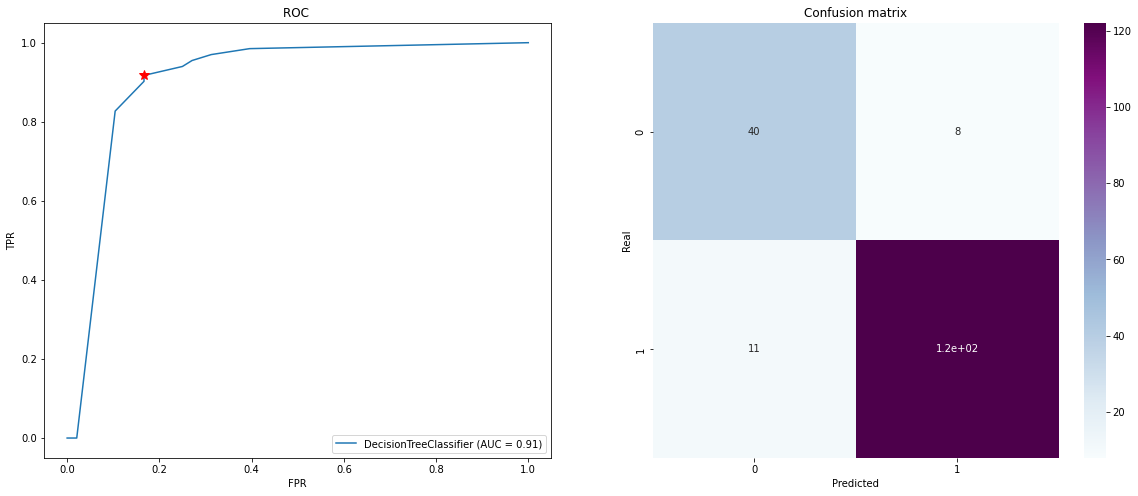

In [68]:
metrics(Dtree_best, y_test, X_test, 'Decision tree '+name)

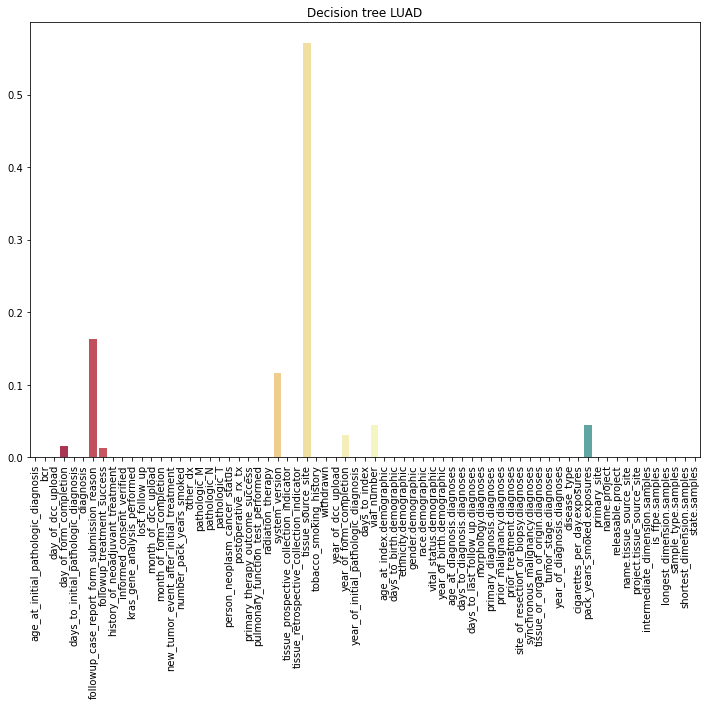

In [69]:
plt.figure(figsize = (12, 8))
sns.barplot(x = data.columns, y = Dtree_best.feature_importances_, palette = 'Spectral')
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Decision tree '+name);

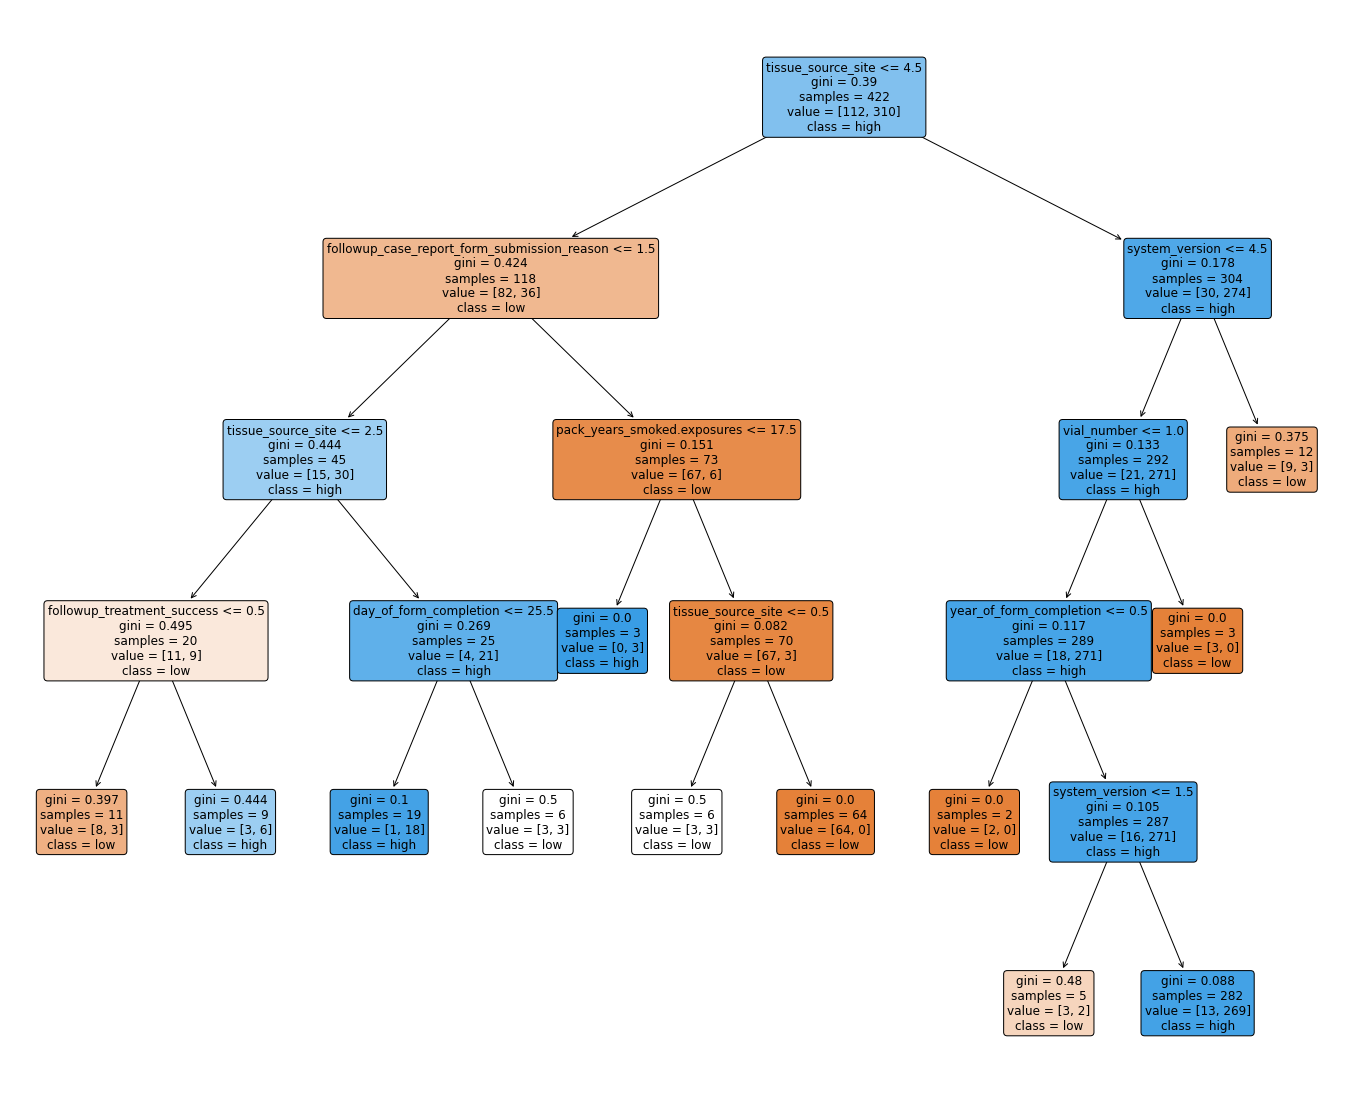

In [70]:
plt.figure(figsize = (24, 20))
plot_tree(Dtree_best,fontsize = 12, feature_names = data.columns, 
          class_names = ['low', 'high'], filled=True, rounded=True)
plt.show()

## Random forest

In [71]:
# metrics(Random_forest_best, y_test, X_test, 'Random forest '+name)

In [72]:
# plt.figure(figsize = (12, 8))
# sns.barplot(x = data.columns, y = Random_forest_best.feature_importances_, palette = 'Spectral')
# plt.tick_params(axis='x', labelrotation = 90)
# plt.title('Random forest '+name);

## Bagging

,Accuracy,ROC-AUC,Precision,Recall
Bagging LUAD,0.911602,0.873277,0.927007,0.954887


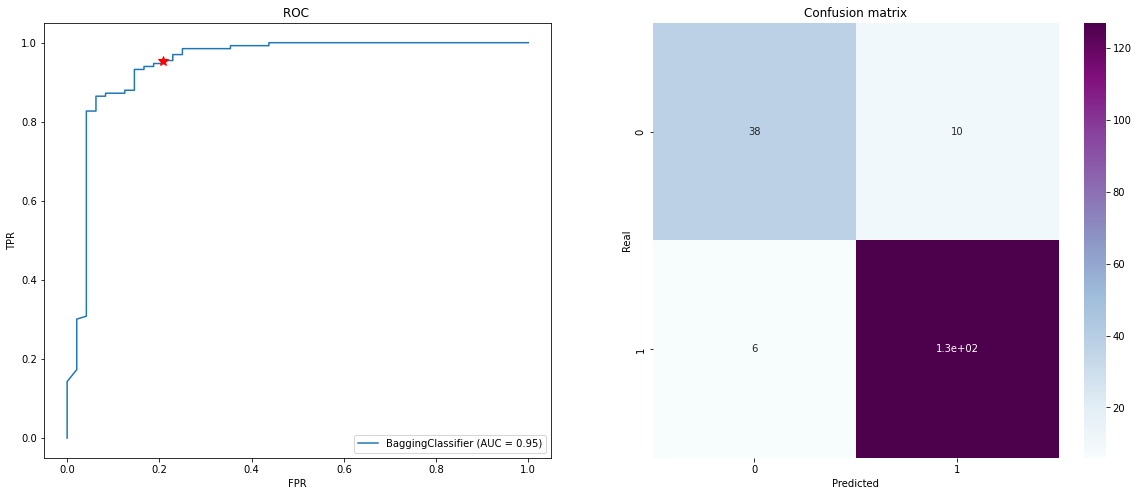

In [73]:
metrics(Bagging, y_test, X_test, 'Bagging '+name)

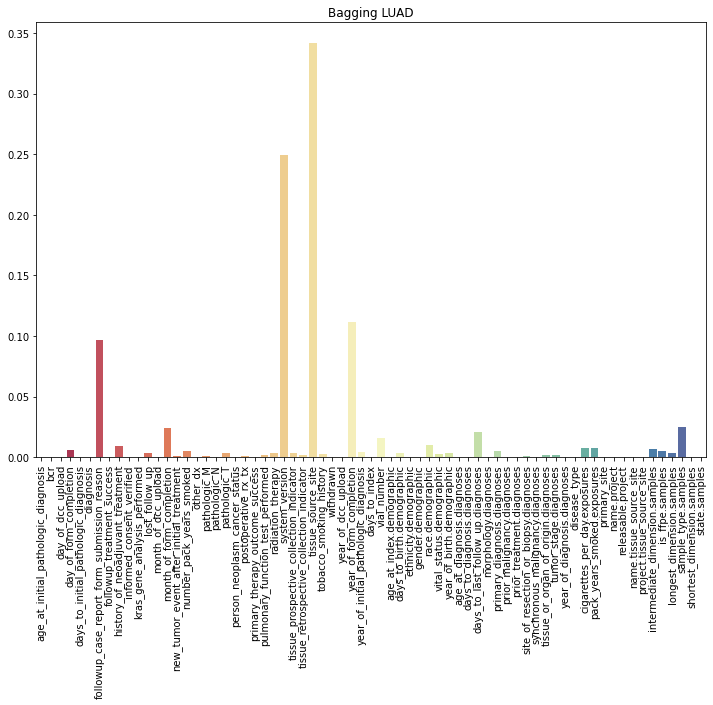

In [74]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in Bagging.estimators_
], axis=0)

plt.figure(figsize = (12, 8))
sns.barplot(x = data.columns, y = feature_importances, palette = 'Spectral')
plt.tick_params(axis='x', labelrotation = 90)
plt.title('Bagging '+name);

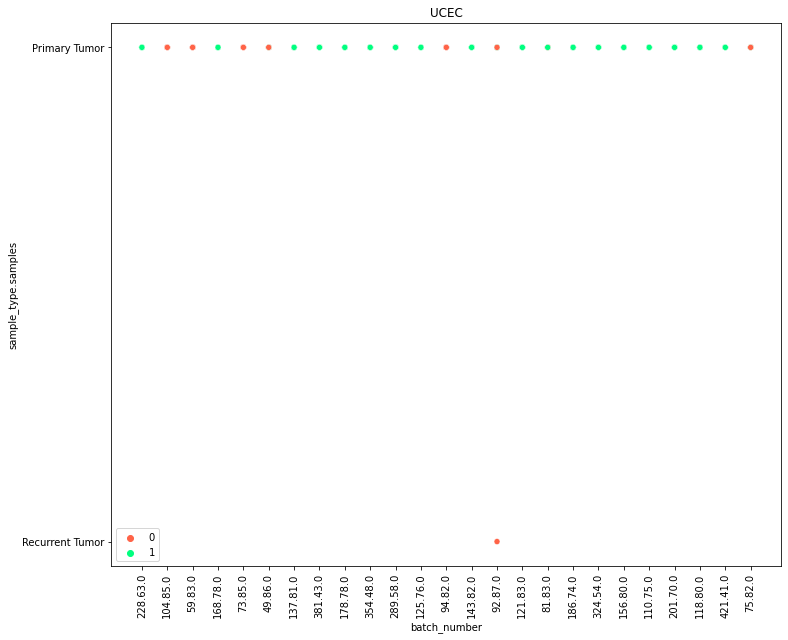

In [20]:
sample_batch = pd.concat([data, mirna22], axis=1)[["sample_type.samples", 
                                                 "batch_number", 
                                                   "hsa-miR-22-3p|+1"]]
y = np.array([1 if i in left else 0 for i in sample_batch.index])

plt.figure(figsize=(12, 10))
sns.scatterplot(x = "batch_number", y = "sample_type.samples", data = sample_batch,
               hue = y, palette = ["tomato", "springgreen"])
plt.title(name)
plt.tick_params(axis='x', labelrotation = 90);

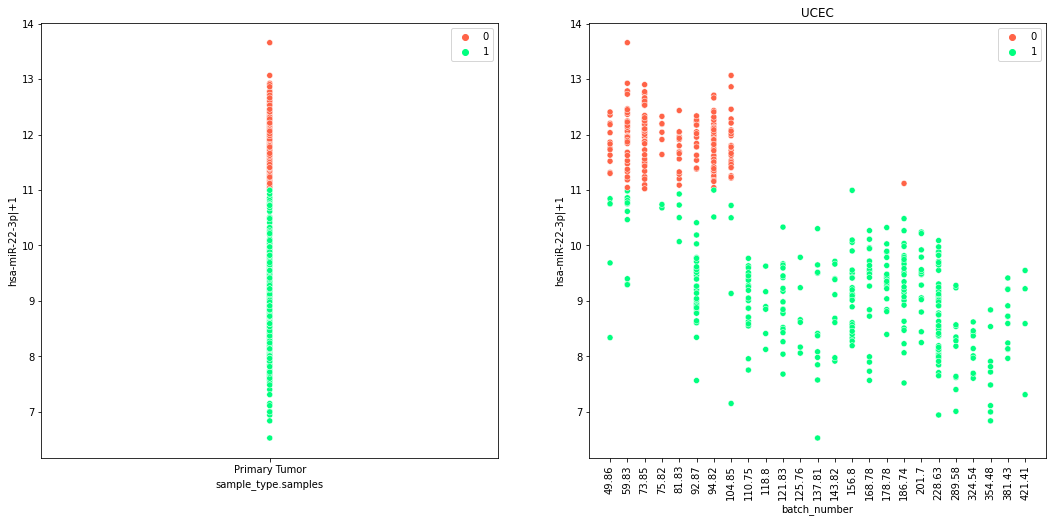

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (18, 8))

new_b = list(map(lambda i: int(i.split('.')[0]) + int(i.split('.')[1])/100, data["batch_number"].values))
data['batch_number'] = new_b
data = data.sort_values(by = 'batch_number')
data['batch_number'] = data['batch_number'].astype(str)

sample = pd.concat([data, mirna22], axis=1)[["hsa-miR-22-3p|+1", "sample_type.samples"]]
y1 = np.array([1 if i in left else 0 for i in sample.index])
race = pd.concat([data, mirna22], axis=1)[["hsa-miR-22-3p|+1", "batch_number"]]
y2 = np.array([1 if i in left else 0 for i in race.index])

plt.title(name)
sns.scatterplot(x = "sample_type.samples", y = "hsa-miR-22-3p|+1", data = sample,
               hue = y1, palette = ["tomato", "springgreen"], ax = axs[0])

sns.scatterplot(x = "batch_number", y = "hsa-miR-22-3p|+1", data = race,
               hue = y2, palette = ["tomato", "springgreen"], ax = axs[1])
axs[1].tick_params(axis='x', labelrotation = 90);